# Image classification

# Phân loại các loại động vật

# 1. Gọi các thư viện cần thiết 

In [2]:
# Import các thư viện cần thiết

import pandas as pd  # Thư viện để xử lý dữ liệu dạng bảng (DataFrame)
import numpy as np  # Thư viện để xử lý các mảng số học, tính toán số học
import torch  # Thư viện chính của PyTorch để xây dựng và huấn luyện mô hình deep learning
import torch.nn as nn  # Gói con của PyTorch cho việc xây dựng các lớp neural network
import torch.optim as optim  # Thư viện chứa các thuật toán tối ưu như SGD, Adam
import torchvision  # Gói con của PyTorch cho các bộ dữ liệu và mô hình trong thị giác máy tính (computer vision)
import torchvision.transforms as transforms  # Thư viện để thực hiện các phép biến đổi dữ liệu, như chuẩn hóa ảnh
from torch.utils.data import Dataset, DataLoader  # Các lớp để xây dựng và quản lý tập dữ liệu và tạo batches

import os  # Thư viện để tương tác với hệ thống tệp (filesystem)
import cv2  # OpenCV để xử lý ảnh và video
import matplotlib.pyplot as plt  # Thư viện để vẽ biểu đồ, hiển thị ảnh
from IPython.display import FileLink  # Thư viện để tạo liên kết tải xuống trong notebook Jupyter

from sklearn.model_selection import train_test_split  # Thư viện để chia tập dữ liệu thành tập huấn luyện và kiểm tra
from PIL import Image  # Thư viện để xử lý và mở các tệp ảnh (JPEG, PNG, ...)

from torchinfo import summary  # Thư viện để hiển thị thông tin về mô hình (số lượng tham số, kích thước output, ...)
from tqdm import tqdm  # Thư viện để tạo thanh tiến trình trong các vòng lặp (hữu ích khi huấn luyện mô hình)
import json  # Thư viện để xử lý dữ liệu JSON
import xml.etree.ElementTree as ET  # Thư viện để phân tích cú pháp các tệp XML

# Import mô hình EfficientNet_B0 từ thư viện torchvision, cùng với các trọng số được huấn luyện sẵn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Xác định thiết bị (device) để huấn luyện mô hình
# Nếu có GPU (CUDA), mô hình sẽ được huấn luyện trên GPU, nếu không sẽ dùng CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Check dataset

In [4]:
# Lấy danh sách các thư mục (danh sách các loại động vật) trong thư mục chứa ảnh huấn luyện
# "breed_list" sẽ chứa tên của các thư mục con, mỗi thư mục đại diện cho một loại động vật.
breed_list = os.listdir("/kaggle/input/animal-image-dataset-90-different-animals/animals/animals")

# Tính số lượng các lớp (loại động vật) dựa trên số lượng thư mục con trong "breed_list"
num_classes = len(breed_list)
print(f"{num_classes} breeds")  # In ra số lượng các loại động vật (các lớp)

# Khởi tạo biến đếm tổng số ảnh huấn luyện
total_train_images = 0

# Duyệt qua từng loại động vật (mỗi giống là một thư mục)
for breed in breed_list:
    # Đếm số lượng tệp (ảnh) trong thư mục của loại động vật hiện tại và cộng vào "total_train_images"
    total_train_images += len(os.listdir(f"/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/{breed}"))

# In ra tổng số ảnh trong tập huấn luyện
print(f"{total_train_images} images")


90 breeds
5400 images


In [59]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

# 3. Crop and save image

In [15]:

# Tạo thư mục 'dataAnimals3' để lưu trữ hình ảnh
os.mkdir('dataAnimals3')

# Tạo các thư mục con cho từng giống chó trong danh sách breed_list
for breed in breed_list:
    os.mkdir(f'dataAnimals3/{breed}')

# In ra số lượng thư mục đã tạo
print('Created {} folders to store images of the different breeds.'.format(len(os.listdir('dataAnimals3'))))

# Lặp qua từng giống chó đã tạo thư mục
for breed in os.listdir('dataAnimals3'):
    # Lặp qua từng file trong thư mục của giống chó hiện tại
    for file in os.listdir(f'/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/{breed}'):
        # Đọc hình ảnh từ thư mục gốc
        img = cv2.imread(f"/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/{breed}/{file}")
        
        # Kiểm tra nếu file không phải hình ảnh hoặc đọc thất bại
        if img is None:
            print(f"Failed to read {file} in breed {breed}")
            continue
        
        # Lưu hình ảnh vào thư mục tương ứng
        cv2.imwrite(f'dataAnimals3/{breed}/{file}', img)

print('All images have been successfully copied to the dataAnimals3 directory.')

Created 90 folders to store images of the different breeds.
All images have been successfully copied to the dataAnimals3 directory.


In [16]:
# Lệnh này sẽ nén thư mục chứa hình ảnh đã được cắt và lưu vào file zip

!zip -r crop_train_animals_image.zip /kaggle/working/dataAnimals3

  adding: kaggle/working/dataAnimals3/ (stored 0%)
  adding: kaggle/working/dataAnimals3/coyote/ (stored 0%)
  adding: kaggle/working/dataAnimals3/coyote/4ebd97228c.jpg (deflated 5%)
  adding: kaggle/working/dataAnimals3/coyote/5ecc7d9008.jpg (deflated 3%)
  adding: kaggle/working/dataAnimals3/coyote/1e4417e510.jpg (deflated 8%)
  adding: kaggle/working/dataAnimals3/coyote/2dd3390eef.jpg (deflated 4%)
  adding: kaggle/working/dataAnimals3/coyote/63f4062ea7.jpg (deflated 8%)
  adding: kaggle/working/dataAnimals3/coyote/0ff564b311.jpg (deflated 4%)
  adding: kaggle/working/dataAnimals3/coyote/46d2138807.jpg (deflated 7%)
  adding: kaggle/working/dataAnimals3/coyote/88bdf2941b.jpg (deflated 10%)
  adding: kaggle/working/dataAnimals3/coyote/90af12d313.jpg (deflated 3%)
  adding: kaggle/working/dataAnimals3/coyote/232c360323.jpg (deflated 5%)
  adding: kaggle/working/dataAnimals3/coyote/23dcefd769.jpg (deflated 7%)
  adding: kaggle/working/dataAnimals3/coyote/0a151f5c78.jpg (deflated 9%)
  

In [17]:
# Nhập hàm FileLink từ thư viện IPython.display để tạo liên kết tải xuống cho file
from IPython.display import FileLink

# Tạo một liên kết đến file zip đã nén, cho phép người dùng tải về file này
FileLink(r'crop_train_animals_image.zip')


/kaggle/working/crop_train_animals_image.zip

# Prepare data train

In [19]:
# Đường dẫn đến thư mục chứa hình ảnh đã cắt
root = "/kaggle/input/crop-animals-img/kaggle/working/dataAnimals3"

# Danh sách để lưu trữ đường dẫn hình ảnh
image_paths = []

# Danh sách để lưu trữ nhãn (labels) tương ứng với từng hình ảnh
labels = []

# Lặp qua từng giống chó trong thư mục gốc
for breed in os.listdir(root):
    # Tạo đường dẫn đầy đủ đến thư mục của động vật hiện tại
    breed_path = os.path.join(root, breed)
    
    # Lặp qua từng hình ảnh trong thư mục của động vật
    for img in os.listdir(breed_path):
        # Tạo đường dẫn đầy đủ đến hình ảnh hiện tại
        image_path = os.path.join(breed_path, img)
        
        # Thêm đường dẫn hình ảnh vào danh sách image_paths
        image_paths.append(image_path)
        
        # Thêm nhãn tương ứng với động vật vào danh sách labels
        labels.append(label_maps[breed])

In [20]:
# Nhập các thư viện cần thiết
from torch.utils.data import Dataset
from PIL import Image

# Định nghĩa lớp TrainDataset, kế thừa từ lớp Dataset của PyTorch
class TrainDataset(Dataset):
    # Hàm khởi tạo, nhận vào dữ liệu hình ảnh (X), nhãn (y) và phép biến đổi (transform)
    def __init__(self, X, y, transform):
        self.transform = transform  # Lưu phép biến đổi (transform) vào thuộc tính
        self.image_paths = X  # Lưu danh sách đường dẫn hình ảnh vào thuộc tính
        self.labels = y  # Lưu danh sách nhãn vào thuộc tính
    
    # Phương thức để trả về số lượng hình ảnh trong tập dữ liệu
    def __len__(self):
        return len(self.image_paths)  # Trả về số lượng hình ảnh

    # Phương thức để lấy một phần tử từ tập dữ liệu theo chỉ số
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Lấy đường dẫn hình ảnh theo chỉ số
        img = Image.open(image_path).convert("RGB")  # Mở hình ảnh và chuyển đổi sang định dạng RGB
        label = self.labels[idx]  # Lấy nhãn tương ứng với hình ảnh
        
        img = self.transform(img)  # Áp dụng phép biến đổi (như làm nhỏ kích thước, chuẩn hóa, v.v.)

        return img, label  # Trả về hình ảnh và nhãn


In [21]:
# Đặt hạt giống (seed) để đảm bảo tính tái lập của kết quả
seed = 42

# Kích thước của tập xác thực (15% tổng số dữ liệu)
val_size = 0.15

# Quyết định xem có nên xáo trộn dữ liệu trước khi chia tách hay không
is_shuffle = True

# Sử dụng hàm train_test_split để chia tách dữ liệu thành tập huấn luyện và tập xác thực
X_train, X_val, y_train, y_val = train_test_split(
    image_paths,  # Danh sách đường dẫn hình ảnh
    labels,       # Danh sách nhãn tương ứng
    test_size=val_size,  # Kích thước của tập xác thực
    random_state=seed,   # Hạt giống để tái lập kết quả
    shuffle=is_shuffle    # Quyết định có xáo trộn dữ liệu hay không
)


In [22]:
# Định nghĩa các phép biến đổi cho tập huấn luyện
train_transform = transforms.Compose([
    # Xoay hình ảnh ngẫu nhiên theo chiều ngang với xác suất 50%
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Xoay hình ảnh ngẫu nhiên trong khoảng -20 đến +20 độ
    transforms.RandomRotation(20),
    
    # Thay đổi kích thước hình ảnh về 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Chuyển đổi hình ảnh thành tensor
    transforms.ToTensor(),
    
    # Chuẩn hóa hình ảnh với giá trị trung bình và độ lệch chuẩn cho từng kênh màu
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    # Biến đổi hình ảnh ngẫu nhiên với các thông số đã định
    transforms.RandomAffine(
        degrees=0,  # Không xoay
        translate=(0.01, 0.12),  # Dịch chuyển ngẫu nhiên trong khoảng 1% chiều rộng và 12% chiều cao
        shear=(0.01, 0.03),  # Biến dạng hình ảnh ngẫu nhiên
    ),
    
    # Xóa ngẫu nhiên một phần của hình ảnh
    transforms.RandomErasing(
        p=0.75,  # Xác suất thực hiện xóa
        scale=(0.01, 0.3),  # Tỷ lệ kích thước vùng xóa
        ratio=(1.0, 1.0),  # Tỷ lệ chiều rộng và chiều cao của vùng xóa
        value=0,  # Giá trị của vùng xóa (màu đen)
        inplace=True  # Thực hiện trực tiếp trên hình ảnh
    )      
])

# Định nghĩa các phép biến đổi cho tập xác thực
val_transform = transforms.Compose([
    # Thay đổi kích thước hình ảnh về 160x160 pixels
    transforms.Resize((160, 160)),
    
    # Chuyển đổi hình ảnh thành tensor
    transforms.ToTensor(),
    
    # Chuẩn hóa hình ảnh với giá trị trung bình và độ lệch chuẩn cho từng kênh màu
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [23]:
# Tạo tập dữ liệu cho quá trình huấn luyện
train_dataset = TrainDataset(
    X_train,  # Danh sách đường dẫn hình ảnh cho tập huấn luyện
    y_train,   # Danh sách nhãn tương ứng cho tập huấn luyện
    transform=train_transform  # Áp dụng các phép biến đổi đã định nghĩa cho tập huấn luyện
)

# Tạo tập dữ liệu cho quá trình xác thực
val_dataset = TrainDataset(
    X_val,  # Danh sách đường dẫn hình ảnh cho tập xác thực
    y_val,   # Danh sách nhãn tương ứng cho tập xác thực
    transform=val_transform  # Áp dụng các phép biến đổi đã định nghĩa cho tập xác thực
)


In [24]:
# Đặt kích thước của mỗi lô (batch) cho tập huấn luyện
train_batch_size = 4

# Đặt kích thước của mỗi lô (batch) cho tập xác thực
val_batch_size = 4

# Tạo DataLoader cho tập huấn luyện
train_loader = DataLoader(
    train_dataset,  # Tập dữ liệu huấn luyện đã được tạo trước đó
    batch_size=train_batch_size,  # Số lượng mẫu trong mỗi lô
    shuffle=True  # Xáo trộn dữ liệu mỗi khi bắt đầu một epoch mới
)

# Tạo DataLoader cho tập xác thực
val_loader = DataLoader(
    val_dataset,  # Tập dữ liệu xác thực đã được tạo trước đó
    batch_size=val_batch_size,  # Số lượng mẫu trong mỗi lô
    shuffle=False  # Không xáo trộn dữ liệu trong tập xác thực
)


# Train model

In [26]:
def evaluation(model, val_loader, criterion):
    # Chuyển mô hình vào chế độ đánh giá
    model.eval()
    
    # Khởi tạo biến để lưu trữ tổng thiệt hại (loss) và số lượng dự đoán chính xác
    val_loss = 0.0
    running_correct = 0 
    total = 0 
    
    # Tắt chế độ theo dõi gradient để tiết kiệm bộ nhớ và tăng tốc độ tính toán
    with torch.no_grad():
        # Duyệt qua từng lô (batch) trong tập xác thực
        for images, labels in val_loader:
            # Chuyển dữ liệu vào thiết bị (CPU hoặc GPU)
            images, labels = images.to(device), labels.to(device)
            
            # Dự đoán đầu ra từ mô hình
            outputs = model(images)
            
            # Tính thiệt hại (loss) dựa trên đầu ra và nhãn thực
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # Cộng dồn thiệt hại
            
            # Tìm nhãn được dự đoán có xác suất cao nhất
            _, predicted = torch.max(outputs.data, 1)
            
            # Cập nhật tổng số mẫu và số lượng dự đoán chính xác
            total += labels.size(0)  # Tổng số nhãn trong lô
            running_correct += (predicted == labels).sum().item()  # Số dự đoán chính xác
    
    # Tính độ chính xác (accuracy)
    accuracy = 100 * running_correct / total
    
    # Tính thiệt hại trung bình cho toàn bộ tập xác thực
    val_loss = val_loss / len(val_loader)
    
    return val_loss, accuracy  # Trả về thiệt hại trung bình và độ chính xác


In [27]:
def save(filename, model):
    # Tạo đường dẫn đầy đủ cho tệp lưu mô hình
    filename = "/kaggle/working/" + filename
    
    # Lưu trạng thái (state_dict) của mô hình vào tệp
    torch.save(model.state_dict(), filename)
    
    # In ra thông báo xác nhận rằng mô hình đã được lưu
    print("Saved model as", filename)


In [28]:
# Tải trọng số (weights) đã được huấn luyện trước cho mô hình EfficientNet B0 từ ImageNet
weights = EfficientNet_B0_Weights.IMAGENET1K_V1

# Khởi tạo mô hình EfficientNet B0 với trọng số đã tải
model = efficientnet_b0(weights=weights)

# Thay đổi lớp phân loại cuối cùng của mô hình
model.classifier[1] = nn.Linear(in_features=1280, out_features=120)

# Chuyển mô hình vào thiết bị tính toán (CPU hoặc GPU)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 192MB/s]


In [29]:
# Khởi tạo hàm mất mát (loss function) cho bài toán phân loại
criterion = nn.CrossEntropyLoss()

# Khởi tạo bộ tối ưu hóa Adam để cập nhật trọng số của mô hình
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4)


In [30]:
# Khởi tạo danh sách để lưu trữ các giá trị mất mát và độ chính xác trong quá trình huấn luyện và xác thực
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Số lượng epoch để huấn luyện
max_epoch = 6
# Độ chính xác tốt nhất khởi tạo
best_accuracy = 50

# Vòng lặp qua từng epoch
for epoch in range(max_epoch):
    # Chuyển mô hình vào chế độ huấn luyện
    model.train()
    
    # Khởi tạo biến để lưu trữ tổng thiệt hại (loss) và số lượng dự đoán chính xác
    running_loss = 0.0
    running_correct = 0   
    total = 0             
    
    print(f"Epoch {epoch + 1}: ", end='')  # In ra số epoch hiện tại
    
    # Duyệt qua từng lô (batch) trong DataLoader của tập huấn luyện
    for _ in tqdm(range(len(train_loader))):
        # Lấy một lô hình ảnh và nhãn từ DataLoader
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(device), labels.to(device)  # Chuyển vào thiết bị tính toán
        
        optimizer.zero_grad()  # Đặt gradient về 0 để không tích lũy từ các vòng lặp trước
        outputs = model(inputs)  # Dự đoán đầu ra từ mô hình
        
        loss = criterion(outputs, labels)  # Tính thiệt hại (loss)
        running_loss += loss.item()  # Cộng dồn thiệt hại cho epoch
        
        loss.backward()  # Tính toán gradient
        optimizer.step()  # Cập nhật trọng số của mô hình
        
        # Tìm nhãn được dự đoán có xác suất cao nhất
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # Cập nhật tổng số mẫu
        running_correct += (predicted == labels).sum().item()  # Cộng dồn số dự đoán chính xác
    
    # Tính toán độ chính xác và thiệt hại trung bình cho epoch hiện tại
    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / len(train_loader)
    
    # Đánh giá mô hình trên tập xác thực
    val_loss, val_accuracy = evaluation(model, val_loader, criterion)
    
    # In ra thông tin về thiệt hại và độ chính xác cho epoch hiện tại
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Kiểm tra nếu độ chính xác trên tập xác thực tốt hơn độ chính xác tốt nhất trước đó
    if val_accuracy > best_accuracy:
        print("saving at epoch", epoch + 1)  # In ra thông báo lưu mô hình
        best_accuracy = val_accuracy  # Cập nhật độ chính xác tốt nhất
        save("animal_weight.pt", model)  # Lưu mô hình vào tệp
        
    # Lưu các giá trị thiệt hại và độ chính xác để vẽ biểu đồ sau này
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


Epoch 1: 

100%|██████████| 1148/1148 [02:25<00:00,  7.89it/s]


Epoch [1/6], Loss: 3.6311, Accuracy: 22.93%, Val Loss: 2.4752, Val Accuracy: 54.81%
saving at epoch 1
Saved model as /kaggle/working/animal_weight.pt
Epoch 2: 

100%|██████████| 1148/1148 [02:11<00:00,  8.71it/s]


Epoch [2/6], Loss: 2.1599, Accuracy: 50.72%, Val Loss: 1.3526, Val Accuracy: 69.01%
saving at epoch 2
Saved model as /kaggle/working/animal_weight.pt
Epoch 3: 

100%|██████████| 1148/1148 [02:07<00:00,  9.02it/s]


Epoch [3/6], Loss: 1.5783, Accuracy: 62.83%, Val Loss: 0.9093, Val Accuracy: 76.42%
saving at epoch 3
Saved model as /kaggle/working/animal_weight.pt
Epoch 4: 

100%|██████████| 1148/1148 [02:07<00:00,  9.03it/s]


Epoch [4/6], Loss: 1.2656, Accuracy: 70.30%, Val Loss: 0.7555, Val Accuracy: 77.53%
saving at epoch 4
Saved model as /kaggle/working/animal_weight.pt
Epoch 5: 

100%|██████████| 1148/1148 [02:05<00:00,  9.18it/s]


Epoch [5/6], Loss: 0.9901, Accuracy: 76.31%, Val Loss: 0.7552, Val Accuracy: 78.77%
saving at epoch 5
Saved model as /kaggle/working/animal_weight.pt
Epoch 6: 

100%|██████████| 1148/1148 [02:02<00:00,  9.39it/s]


Epoch [6/6], Loss: 0.8710, Accuracy: 78.75%, Val Loss: 0.6243, Val Accuracy: 82.22%
saving at epoch 6
Saved model as /kaggle/working/animal_weight.pt


# Predict

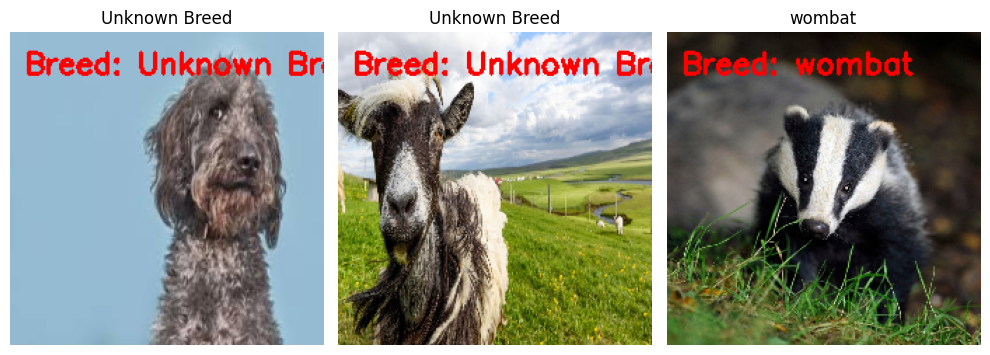

In [73]:
import cv2
import numpy as np
import torch
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm dự đoán cho nhiều ảnh
def predict_multiple_images(model, image_paths, label_maps_rev, transform, device):
    model.to(device)  # Chuyển mô hình sang GPU nếu có
    model.eval()  # Đặt mô hình ở chế độ đánh giá (evaluation mode)
    predictions = []  # Khởi tạo danh sách để lưu kết quả dự đoán
    
    for image_path in image_paths:
        # Đọc và tiền xử lý ảnh
        img = Image.open(image_path).convert("RGB")  # Đọc ảnh và chuyển đổi sang định dạng RGB
        img = transform(img).unsqueeze(0).to(device)  # Tiền xử lý ảnh và chuyển vào thiết bị
        
        # Dự đoán ảnh
        with torch.no_grad():  # Không tính gradient để tiết kiệm bộ nhớ
            output = model(img)  # Dự đoán đầu ra từ mô hình
            _, predicted = torch.max(output, 1)  # Lấy nhãn được dự đoán có xác suất cao nhất
            breed_name = label_maps_rev.get(predicted.item(), None)  # Using None as a fallback if index not found
            if breed_name is None:
                print(f"Warning: Unknown breed index {predicted.item()} at image {image_path}")
                breed_name = "Unknown Breed"  # or skip processing this image
              # Chuyển đổi nhãn dự đoán thành tên động vật
            predictions.append((image_path, breed_name))  # Lưu đường dẫn ảnh và tên động vật
    
    return predictions  # Trả về danh sách kết quả dự đoán

import matplotlib.pyplot as plt

# Hiển thị ảnh và kết quả dự đoán bằng matplotlib
def display_predictions(predictions):
    images = []  # Khởi tạo danh sách để lưu các ảnh đã xử lý
    
    for image_path, breed_name in predictions:
        # Đọc ảnh bằng OpenCV
        img = cv2.imread(image_path)  # Đọc ảnh từ đường dẫn
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển đổi màu sắc từ BGR sang RGB
        img = cv2.resize(img, (224, 224))  # Thay đổi kích thước ảnh cho dễ nhìn
        
        # Thêm nhãn dự đoán lên ảnh
        cv2.putText(img, f"Breed: {breed_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)  # Ghi nhãn động vật lên ảnh
        images.append(img)  # Lưu ảnh đã xử lý vào danh sách
    
    # Hiển thị các ảnh với nhãn dự đoán
    plt.figure(figsize=(10, 5))  # Tạo một figure mới với kích thước 10x5
    for idx, img in enumerate(images):
        plt.subplot(1, len(images), idx + 1)  # Tạo subplot cho từng ảnh
        plt.imshow(img)  # Hiển thị ảnh
        plt.title(predictions[idx][1])  # Ghi tiêu đề là tên động vật dự đoán
        plt.axis('off')  # Ẩn trục
    
    plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các subplot
    plt.show()  # Hiển thị tất cả các ảnh

# Sử dụng hàm để dự đoán và hiển thị ảnh
image_paths = [
    "/kaggle/input/crop-animals-img/kaggle/working/dataAnimals3/dog/01c6b7230c.jpg",
    "/kaggle/input/crop-animals-img/kaggle/working/dataAnimals3/goat/037bf28bc5.jpg",
    "/kaggle/input/crop-animals-img/kaggle/working/dataAnimals3/badger/00f56e5c92.jpg"
]  # Thay thế bằng đường dẫn ảnh thực tế

predictions = predict_multiple_images(model, image_paths, label_maps_rev, val_transform, device)  # Gọi hàm dự đoán
display_predictions(predictions)  # Gọi hàm hiển thị kết quả


# Một vài mô hình CNN nổi tiếng

# VGG-16 

In [53]:
from torch import nn
import torch

# Định nghĩa lớp VGG16 với số lớp đầu ra là 10 (mặc định)
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        # Khối 1: Conv2d, BatchNorm2d, ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Lớp tích chập (3 đầu vào, 64 đầu ra)
            nn.BatchNorm2d(64),  # Chuẩn hóa đầu ra của Conv2d
            nn.ReLU()  # Hàm kích hoạt ReLU
        )
        
        # Khối 2: Conv2d, BatchNorm2d, ReLU, MaxPool
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Conv2d tiếp tục với 64 đầu vào và đầu ra
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Giảm kích thước với MaxPooling
        )

        # Khối 3: Conv2d, BatchNorm2d, ReLU
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Tích chập từ 64 lên 128 kênh
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Khối 4: Conv2d, BatchNorm2d, ReLU, MaxPool
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Tích chập từ 128 lên 128 kênh
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling để giảm kích thước
        )

        # Khối 5: Conv2d, BatchNorm2d, ReLU
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Tích chập từ 128 lên 256 kênh
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Khối 6: Conv2d, BatchNorm2d, ReLU
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Tích chập từ 256 lên 256 kênh
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Khối 7: Conv2d, BatchNorm2d, ReLU, MaxPool
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling để giảm kích thước
        )

        # Khối 8: Conv2d, BatchNorm2d, ReLU
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Tích chập từ 256 lên 512 kênh
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Khối 9: Conv2d, BatchNorm2d, ReLU
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Khối 10: Conv2d, BatchNorm2d, ReLU, MaxPool
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling để giảm kích thước
        )

        # Khối 11: Conv2d, BatchNorm2d, ReLU
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Khối 12: Conv2d, BatchNorm2d, ReLU
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Khối 13: Conv2d, BatchNorm2d, ReLU, MaxPool
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling để giảm kích thước
        )

        # Các lớp fully connected
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout để giảm overfitting
            nn.Linear(7*7*512, 4096),  # Tầng fully connected với 4096 đầu ra
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes)  # Lớp cuối cùng cho phân loại, với số lớp đầu ra bằng `num_classes`
        )
        
    # Định nghĩa hàm forward để truyền dữ liệu qua các lớp của mạng
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)  # Làm phẳng tensor để đưa vào các lớp fully connected
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out  # Trả về kết quả dự đoán của mạng

# Khởi tạo mô hình VGG16 và in cấu trúc mô hình
model = VGG16()
print(model)


VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

# VGG-19

In [54]:
from torch import nn
import torch

# Định nghĩa lớp VGGNet19 với số lượng lớp đầu ra là 1000 (mặc định)
class VGGNet19(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.__name__ = "VGGNet19"  # Đặt tên cho mô hình là VGGNet19

        # Cấu hình cho các khối convolution (tầng tích chập)
        self.conv_configs = [
            # Tầng 1 và 2: 2 lớp Conv với 3 đầu vào và 64 đầu ra
            {
                "in_channels": 3,
                "out_channels": 64,
                "num_convs": 2,
            },
            # Tầng 3 và 4: 2 lớp Conv với 64 đầu vào và 128 đầu ra
            {
                "in_channels": 64,
                "out_channels": 128,
                "num_convs": 2,
            },
            # Tầng 5, 6, 7, 8: 4 lớp Conv với 128 đầu vào và 256 đầu ra
            {
                "in_channels": 128,
                "out_channels": 256,
                "num_convs": 4,
            },
            # Tầng 9, 10, 11, 12: 4 lớp Conv với 256 đầu vào và 512 đầu ra
            {
                "in_channels": 256,
                "out_channels": 512,
                "num_convs": 4,
            },
            # Tầng 13, 14, 15, 16: 4 lớp Conv với 512 đầu vào và 512 đầu ra
            {
                "in_channels": 512,
                "out_channels": 512,
                "num_convs": 4,
            },
        ]

        # Cấu hình cho các khối fully connected (tầng kết nối đầy đủ)
        self.fc_configs = [
            # Tầng 17: với 512*7*7 đầu vào và 4096 đầu ra
            {
                "in_features": 512 * 7 * 7,
                "out_features": 4096,
            },
            # Tầng 18: với 4096 đầu vào và 4096 đầu ra
            {
                "in_features": 4096,
                "out_features": 4096,
            },
            # Tầng 19: với 4096 đầu vào và số lớp đầu ra (mặc định 1000)
            {
                "in_features": 4096,
                "out_features": 1000,
            },
        ]

        # Tạo các khối convolution và fully connected
        self.conv_blocks = self._build_conv_blocks()
        self.fc_blocks = self._build_fc_blocks()

    # Hàm xây dựng các khối convolution dựa trên cấu hình
    def _build_conv_blocks(self):
        blocks = []
        for conv_config in self.conv_configs:
            in_channels = conv_config["in_channels"]
            out_channels = conv_config["out_channels"]
            num_convs = conv_config["num_convs"]

            layers = []
            # Tạo các lớp Conv2d, BatchNorm2d và ReLU theo số lần conv
            for _ in range(num_convs):
                layers.append(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    )
                )
                layers.append(nn.BatchNorm2d(out_channels))  # Sử dụng BatchNorm để ổn định huấn luyện
                layers.append(nn.ReLU(inplace=True))  # Sử dụng ReLU làm hàm kích hoạt
                in_channels = out_channels  # Cập nhật số lượng kênh đầu vào cho lớp tiếp theo

            # Thêm MaxPooling để giảm kích thước ảnh (pooling sau các lớp Conv)
            layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))

            blocks.extend(layers)  # Thêm các lớp vào danh sách các khối

        return nn.Sequential(*blocks)  # Chuyển danh sách thành nn.Sequential để dễ sử dụng

    # Hàm xây dựng các khối fully connected dựa trên cấu hình
    def _build_fc_blocks(self):
        blocks = []

        for i, fc_config in enumerate(self.fc_configs):
            in_features = fc_config["in_features"]
            out_features = fc_config["out_features"]

            # Nếu không phải là lớp cuối cùng, thêm ReLU và Dropout để tránh overfitting
            if i < len(self.fc_configs) - 1:
                layers = [
                    nn.Linear(in_features=in_features, out_features=out_features),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),  # Dropout với xác suất 0.5 để giảm overfitting
                ]
            else:
                # Lớp cuối cùng chỉ cần lớp Linear (không cần ReLU hay Dropout)
                layers = [nn.Linear(in_features=in_features, out_features=out_features)]

            blocks.extend(layers)  # Thêm các lớp vào danh sách các khối

        return nn.Sequential(*blocks)  # Chuyển danh sách thành nn.Sequential để dễ sử dụng

    # Định nghĩa hàm forward (truyền dữ liệu đầu vào qua các lớp của mạng)
    def forward(self, x):
        x = self.conv_blocks(x)  # Truyền dữ liệu qua các khối convolution
        x = x.flatten(start_dim=1)  # Làm phẳng đầu ra trước khi đưa vào các lớp fully connected

        x = self.fc_blocks(x)  # Truyền dữ liệu qua các khối fully connected

        return x  # Trả về kết quả

# Khởi tạo mô hình VGGNet19 và in cấu trúc mô hình
model = VGGNet19()
print(model)


VGGNet19(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=Fals

# InceptionNet

In [55]:
import torch
from torch import nn
import torch.nn.functional as F

# Lớp ConvBlock: định nghĩa một khối convolution đơn giản với Batch Normalization và ReLU
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        # Sử dụng convolution 2D với các tham số truyền vào
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        # Áp dụng Batch Normalization để ổn định việc huấn luyện
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Áp dụng convolution, batch normalization và hàm kích hoạt ReLU
        x = self.bn(self.conv(x))
        return F.relu(x, inplace=True)

# Lớp InceptionBlock: khối Inception chính với nhiều nhánh (branches)
class InceptionBlock(nn.Module):
    def __init__(
        self,
        in_channels,             # Số lượng channels đầu vào
        out_1x1,                 # Số lượng channels của nhánh 1x1
        outinception_3x3_reduced, # Số lượng channels giảm trước khi áp dụng 3x3
        outinception_3x3,        # Số lượng channels của nhánh 3x3
        outinception_5x5_reduced, # Số lượng channels giảm trước khi áp dụng 5x5
        outinception_5x5,        # Số lượng channels của nhánh 5x5 (thực tế là hai lớp 3x3)
        out_pool                 # Số lượng channels của nhánh MaxPooling
    ):
        super().__init__()

        # Nhánh 1: Convolution 1x1 đơn giản
        self.branch1 = ConvBlock(
            in_channels, out_1x1, kernel_size=1, stride=1
        )

        # Nhánh 2: Convolution 1x1 để giảm số channels sau đó là Convolution 3x3
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, outinception_3x3_reduced, kernel_size=1),
            ConvBlock(outinception_3x3_reduced, outinception_3x3, kernel_size=3, padding=1),
        )

        # Nhánh 3: Convolution 1x1 giảm số lượng channels rồi áp dụng hai lớp Conv 3x3
        # Điều này hiệu quả hơn so với việc sử dụng một lớp 5x5 trực tiếp.
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, outinception_5x5_reduced, kernel_size=1),
            ConvBlock(outinception_5x5_reduced, outinception_5x5, kernel_size=3, padding=1),
            ConvBlock(outinception_5x5, outinception_5x5, kernel_size=3, padding=1),
        )

        # Nhánh 4: MaxPooling để giảm kích thước không gian, sau đó là Convolution 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Áp dụng từng nhánh và kết hợp kết quả từ các nhánh bằng hàm torch.cat
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        y3 = self.branch3(x)
        y4 = self.branch4(x)

        # Kết hợp đầu ra từ các nhánh bằng cách ghép lại theo chiều số lượng channels
        return torch.cat([y1, y2, y3, y4], 1)

# Lớp Inception: định nghĩa toàn bộ mô hình Inception với các khối liên tiếp
class Inception(nn.Module):
    def __init__(self, img_channel):
        super().__init__()

        # Lớp convolution đầu tiên để xử lý đầu vào
        self.first_layers = nn.Sequential(
            ConvBlock(img_channel, 192, kernel_size=3, padding=1)
        )

        # Các khối Inception nối tiếp nhau
        self.inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        # Lớp MaxPooling để giảm kích thước không gian
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Tiếp tục thêm các khối Inception trong tầng 4 và 5
        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Lớp trung bình gộp (AvgPool) để giảm kích thước không gian về 1x1
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=1)
        # Lớp fully connected để đưa ra kết quả phân loại
        self.fc = nn.Linear(1024, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out: torch.Tensor
        # Áp dụng lớp convolution đầu tiên
        out = self.first_layers(x)

        # Áp dụng các khối Inception trong tầng 3
        out = self.inception_3a(out)
        out = self.inception_3b(out)
        out = self.max_pool(out)

        # Áp dụng các khối Inception trong tầng 4
        out = self.inception_4a(out)
        out = self.inception_4b(out)
        out = self.inception_4c(out)
        out = self.inception_4d(out)
        out = self.inception_4e(out)
        out = self.max_pool(out)

        # Áp dụng các khối Inception trong tầng 5
        out = self.inception_5a(out)
        out = self.inception_5b(out)

        # Áp dụng lớp trung bình gộp và đưa về dạng vector
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        # Trả về kết quả sau khi qua lớp fully connected
        return self.fc(out)

# Hàm main: tạo mô hình và kiểm tra kích thước đầu ra với một input mẫu
def main() -> None:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = Inception(1).to(device)  # Khởi tạo mô hình Inception với 1 channel đầu vào
    x = torch.randn(3, 1, 32, 32, device=device)  # Tạo một input giả kích thước (3, 1, 32, 32)

    y: torch.Tensor = net(x)  # Tính toán đầu ra của mô hình với input x
    print(f'{y.size() = }')  # In kích thước của đầu ra

# Tạo mô hình Inception và in cấu trúc mô hình
model = Inception(1)
print(model)


Inception(
  (first_layers): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (inception_3a): InceptionBlock(
    (branch1): ConvBlock(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch3): Sequential(
      (0): ConvBlock(
    

# ResNet

In [56]:
from torch import nn
import torch

# Lớp Downsample: giảm kích thước không gian (spatial dimensions) của input nếu cần
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        # Sử dụng convolution 1x1 để giảm số lượng channels
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=stride, bias=False
        )
        # Áp dụng Batch Normalization để ổn định việc huấn luyện
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Áp dụng convolution và Batch Normalization
        x = self.conv(x)
        x = self.bn(x)
        return x


# Lớp Bottleneck: khối cơ bản của ResNet-50, có cấu trúc gồm ba lớp convolution
class Bottleneck(nn.Module):
    def __init__(
        self, in_channels, hidden_channels, out_channels, stride=1, downsample=None
    ):
        super().__init__()
        # Lớp conv1: convolution 1x1 để giảm số lượng channels
        self.conv1 = nn.Conv2d(
            in_channels, hidden_channels, kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        
        # Lớp conv2: convolution 3x3 để học đặc trưng không gian
        self.conv2 = nn.Conv2d(
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        
        # Lớp conv3: convolution 1x1 để tăng số lượng channels
        self.conv3 = nn.Conv2d(
            hidden_channels, out_channels, kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Downsample nếu cần để đảm bảo kích thước khớp với đầu ra
        self.downsample = downsample
        
        # Hàm kích hoạt ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Lưu lại giá trị input để dùng cho kết nối tắt (skip connection)

        # Áp dụng conv1, bn1
        out = self.conv1(x)
        out = self.bn1(out)

        # Áp dụng conv2, bn2
        out = self.conv2(out)
        out = self.bn2(out)

        # Áp dụng conv3, bn3
        out = self.conv3(out)
        out = self.bn3(out)

        # Sử dụng downsample nếu cần để khớp kích thước giữa input và output
        if self.downsample is not None:
            identity = self.downsample(x)

        # Cộng giá trị input (identity) với output từ các lớp convolution
        out += identity
        
        # Áp dụng hàm kích hoạt ReLU
        out = self.relu(out)

        return out


# Lớp ResNet50: định nghĩa kiến trúc tổng thể của mạng ResNet-50
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.__name__ = "ResNet50"

        # Lớp conv1: convolution 7x7 để xử lý đầu vào (input) ban đầu
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        
        # Lớp maxpool1: giảm kích thước không gian của output
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Định nghĩa layer1: gồm 3 Bottleneck, trong đó block đầu tiên có downsample
        self.layer1 = nn.Sequential(
            Bottleneck(
                in_channels=64,
                hidden_channels=64,
                out_channels=256,
                stride=1,
                downsample=Downsample(in_channels=64, out_channels=256, stride=1),
            ),
            Bottleneck(in_channels=256, hidden_channels=64, out_channels=256, stride=1),
            Bottleneck(in_channels=256, hidden_channels=64, out_channels=256, stride=1),
        )
        
        # Định nghĩa layer2: gồm 4 Bottleneck, trong đó block đầu tiên có downsample
        self.layer2 = nn.Sequential(
            Bottleneck(
                in_channels=256,
                hidden_channels=128,
                out_channels=512,
                stride=2,
                downsample=Downsample(in_channels=256, out_channels=512, stride=2),
            ),
            Bottleneck(
                in_channels=512, hidden_channels=128, out_channels=512, stride=1
            ),
            Bottleneck(
                in_channels=512, hidden_channels=128, out_channels=512, stride=1
            ),
            Bottleneck(
                in_channels=512, hidden_channels=128, out_channels=512, stride=1
            ),
        )
        
        # Định nghĩa layer3: gồm 6 Bottleneck, trong đó block đầu tiên có downsample
        self.layer3 = nn.Sequential(
            Bottleneck(
                in_channels=512,
                hidden_channels=256,
                out_channels=1024,
                stride=2,
                downsample=Downsample(in_channels=512, out_channels=1024, stride=2),
            ),
            Bottleneck(
                in_channels=1024, hidden_channels=256, out_channels=1024, stride=1
            ),
            Bottleneck(
                in_channels=1024, hidden_channels=256, out_channels=1024, stride=1
            ),
            Bottleneck(
                in_channels=1024, hidden_channels=256, out_channels=1024, stride=1
            ),
            Bottleneck(
                in_channels=1024, hidden_channels=256, out_channels=1024, stride=1
            ),
            Bottleneck(
                in_channels=1024, hidden_channels=256, out_channels=1024, stride=1
            ),
        )
        
        # Định nghĩa layer4: gồm 3 Bottleneck, trong đó block đầu tiên có downsample
        self.layer4 = nn.Sequential(
            Bottleneck(
                in_channels=1024,
                hidden_channels=512,
                out_channels=2048,
                stride=2,
                downsample=Downsample(in_channels=1024, out_channels=2048, stride=2),
            ),
            Bottleneck(
                in_channels=2048, hidden_channels=512, out_channels=2048, stride=1
            ),
            Bottleneck(
                in_channels=2048, hidden_channels=512, out_channels=2048, stride=1
            ),
        )
        
        # Lớp avgpool: adaptive pooling để giảm kích thước xuống 1x1
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        # Lớp fully connected (fc) để phân loại đầu ra
        self.fc = nn.Linear(2048, num_classes)

    # Định nghĩa hàm forward: xử lý các bước tính toán trên input x
    def forward(self, x):
        # Xử lý đầu vào qua conv1, bn1, ReLU, maxpool1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Xử lý qua các layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Sử dụng adaptive average pooling và flatten để chuyển về vector
        x = self.avgpool(x)
        x = x.flatten(start_dim=1)
        
        # Dùng fully connected layer để đưa ra kết quả cuối cùng
        x = self.fc(x)

        return x

# Tạo mô hình ResNet-50 và in ra cấu trúc của nó
model = ResNet50()
print(model)


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Downsample(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b